**Environment and Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set(style="whitegrid", rc={"figure.figsize":(12,6)})


**Load the Excel and Inspect**

In [3]:
data_path = Path ("Region-series.xlsx")

xls = pd.ExcelFile(data_path)
print("Sheets Found:", xls.sheet_names)

sheet_name = xls.sheet_names[0]
df_raw = pd.read_excel(data_path, sheet_name=sheet_name)

print ("Raw Shape:", df_raw.shape)
display(df_raw.head(3))
display(df_raw.columns)

Sheets Found: ['Dataset']
Raw Shape: (330930, 7)


,Date,Region,Product,Visitor Type,Origin,Annual Spend,Monthly Spend
0,2018-01-31,Auckland,Accommodation services,International,Africa and Middle East,0.27,0.27
1,2018-01-31,Auckland,Accommodation services,International,Australia,8.99,8.99
2,2018-01-31,Auckland,Accommodation services,International,Canada,0.32,0.32


Index(['Date', 'Region', 'Product', 'Visitor Type', 'Origin', 'Annual Spend',
       'Monthly Spend'],
      dtype='object')

**Standardise Column Names and Create a Proper Monthly Date**

In [5]:
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

region_col = next ((c for c in df.columns if "region" in c or "rto" in c), None)
year_col = next ((c for c in df.columns if c in ["year", "yr"]), None)
month_col = next ((c for c in df.columns if "month" in c), None)
date_col = next ((c for c in df.columns if c in ["date", "period", "month_ned", "yyyymm", "year_month"]), None)
candidate_value_cols = [c for c in df.columns if c not in [region_col, year_col, month_col, date_col] and df[c].dtype !='object']
value_col = candidate_value_cols[0] if candidate_value_cols else None

#if the spend is stored in a non-numeric column;

if value_col is None:
  for c in ["value", "spend", "amount", "total"]:
    if c in df.columns:
      value_col = c
      break

print ("Detected columns ->",
       "\nregion:", region_col,
       "\nyear:", year_col,
       "\nmonth:", month_col,
       "\ndate:", date_col,
       "\nvalue:", value_col)

#Build a proper monthly date column

if date_col and date_col in df.columns:
  df["date"] = pd.to_datetime(df[date_col])
elif year_col and month_col:
  month_map = {m.lower(): i for i, m in enumerate (["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov","Dec"], start = 1)}
  if df[month_col].dtype == 'object':
    df["month_num"] = df[month_col].astype(str).str[:3].str.title().map(month_map).fillna(df[month_col])
  else:
    df["month_num"] = df[month_col]
  df["date"]= pd.to_datetime(dict(year=df[year_col].astype(int), month=df["month_num"].astype(int), day=1))
else:
  raise ValueError("Could not detect date columns. Inspect df_raw.columns and adjust detection logic.")

#Clean Value
df[value_col]=pd.to_numeric(df[value_col], errors="coerce")

keep_cols = ["date", region_col, value_col]
df = df[keep_cols].dropna(subset=["date", value_col])
df = df.sort_values(["date", region_col]).reset_index(drop=True)

df.rename(columns={region_col: "region", value_col: "spend"}, inplace=True)
display(df.head())

Detected columns -> 
region: region 
year: None 
month: monthly spend 
date: date 
value: annual spend


,date,region,spend
0,2018-01-31,Auckland,0.27
1,2018-01-31,Auckland,8.99
2,2018-01-31,Auckland,0.32
3,2018-01-31,Auckland,1.27
4,2018-01-31,Auckland,0.87


**Build a Nation Series and Regional Series**

In [7]:
nz = df.groupby("date", as_index=False)["spend"].sum().rename(columns={"spend":"spend_nz"})

region_ts = df.pivot_table(index="date", columns="region", values="spend", aggfunc="sum").sort_index()

print ("National series:", nz.shape, "Regional Matrix:", region_ts.shape)
display(nz.tail())
display(region_ts.iloc[-3:].T.head())

National series: (90, 2) Regional Matrix: (90, 16)


,date,spend_nz
85,2025-02-28,"15,065.09"
86,2025-03-31,"14,988.82"
87,2025-04-30,"15,022.27"
88,2025-05-31,"15,044.96"
89,2025-06-30,"15,028.09"


date,2025-04-30,2025-05-31,2025-06-30
region,,,
Auckland,"3,571.19","3,588.79","3,591.63"
Bay of Plenty,"1,218.07","1,221.01","1,218.27"
Canterbury,"2,005.78","2,005.44","2,004.50"
Gisborne,84.83,85.25,86.15
Hawke's Bay,433.94,433.27,432.14


**Recovery Index (2019 base = 100) and YoY growth**

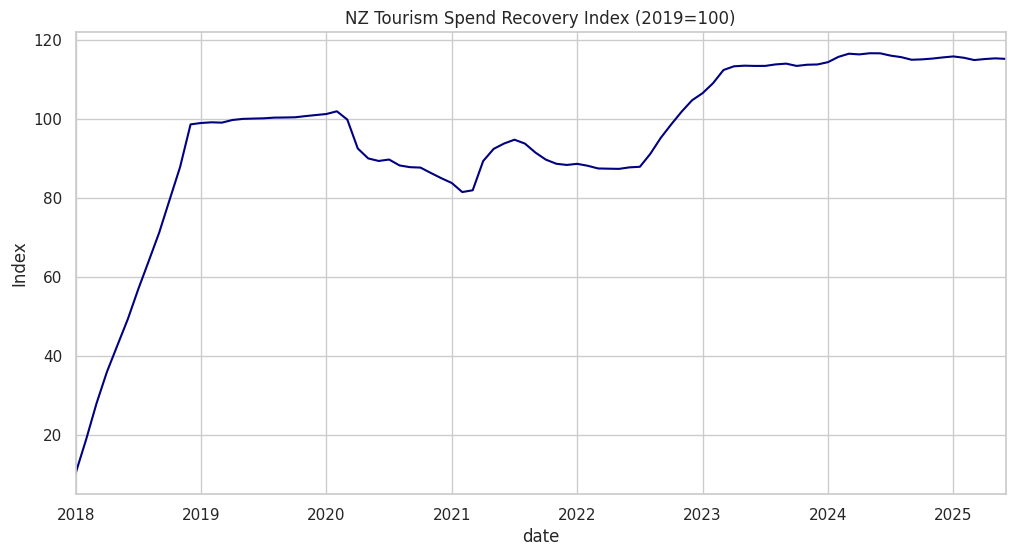

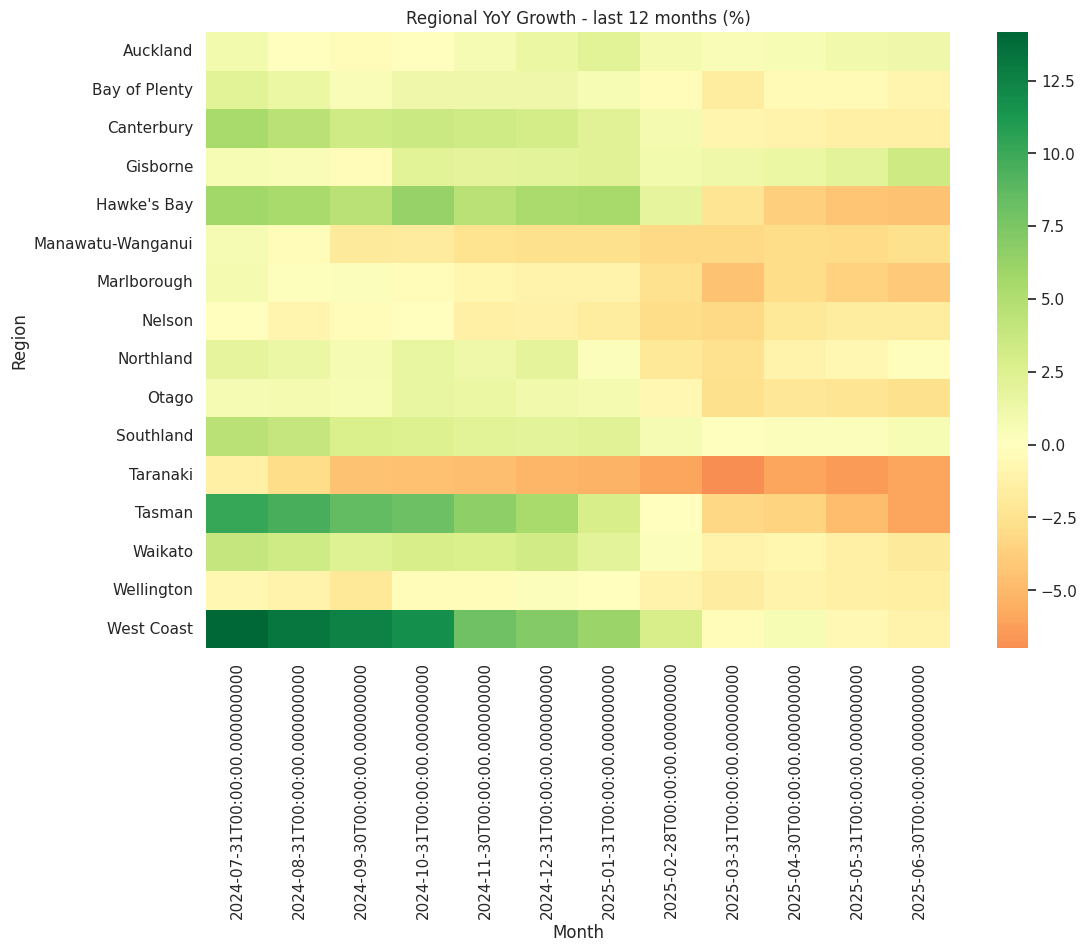

In [8]:
def recovery_index (series, base_year=2019):
  base = series[series.index.year == base_year].mean()
  return (series/base)*100


nz_idx = nz.set_index("date")["spend_nz"].pipe(recovery_index)

region_idx = region_ts.apply(recovery_index, base_year=2019)

nz_yoy = nz.set_index("date")["spend_nz"].pct_change(12)*100

fig,ax = plt.subplots()
nz_idx.plot(ax=ax, color="navy")
ax.set_title("NZ Tourism Spend Recovery Index (2019=100)")
ax.set_ylabel("Index")
plt.show()

#Heatmap of recent YoY by region (last 12 months)
recent_yoy = region_ts.pct_change(12).iloc[-12:]*100
plt.figure(figsize=(12,8))
sns.heatmap(recent_yoy.T, cmap="RdYlGn", center=0, annot=False)
plt.title("Regional YoY Growth - last 12 months (%)")
plt.xlabel("Month")
plt.ylabel("Region")
plt.show()

**Choose a Region and Prepare a Clean Forecasting Series**

Forecast target region: Auckland


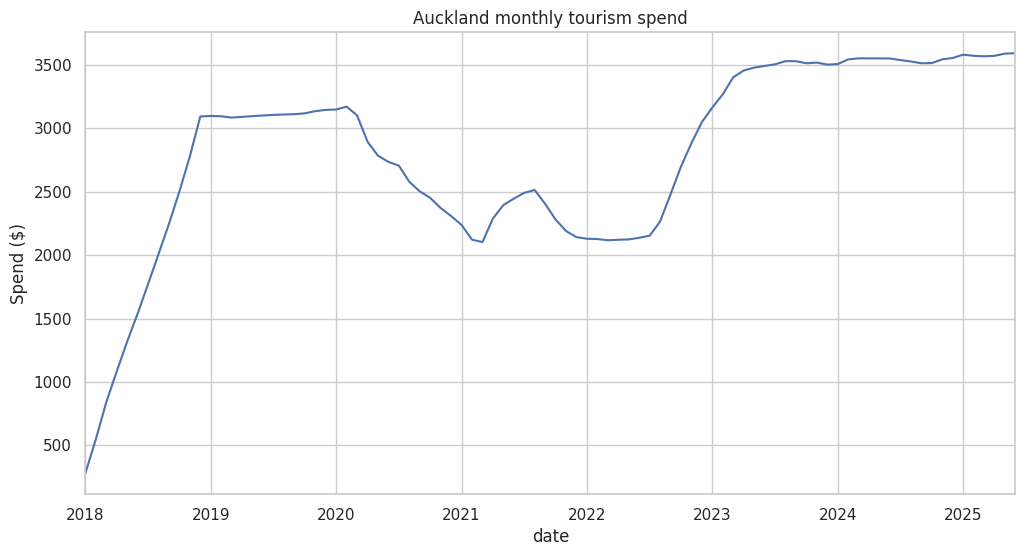

In [10]:
target_region = "Auckland"
if target_region not in region_ts.columns:
  print (f" '{target_region}' not found. Available regions include:\n", list(region_ts.columns)[:10], "...")
else:
  print(f"Forecast target region: {target_region}")

y = region_ts[target_region].dropna()

y.plot()
plt.title(f"{target_region} monthly tourism spend")
plt.ylabel("Spend ($)")
plt.show()

**Train/test Split and Seasonal Order Search**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_date

Best by AIC: (1, 1, 1) (1, 1, 1) AIC: 571.7780653243893


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Test RMSE: 147
Test MAPE: 3.8%


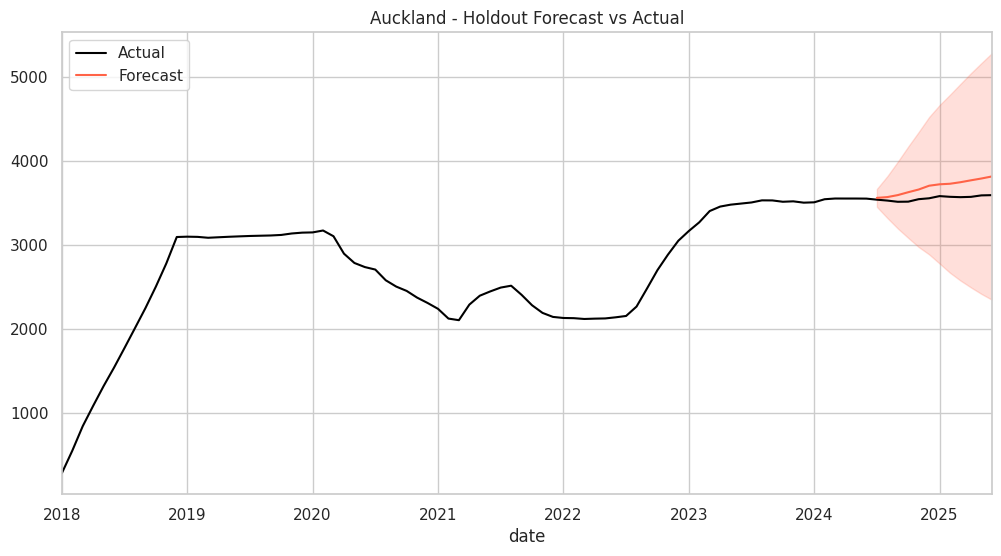

In [15]:
from sklearn.metrics import mean_squared_error

#Holdout last 12 months
h=12
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

#Small grid for (p,d,q) and (P,D,Q, s=12)
p = d = q = range (0,2)
P = D = Q = range (0,2)
seasonal_period = 12

orders = list(product (p,d,q))
seasonal_orders = list(product(P,D,Q)) # Corrected typo: products -> product
candidates = []

for order in orders:
  for sorder in seasonal_orders:
    try:
      model = SARIMAX(
          y_train,
          order=order,
          seasonal_order=(sorder[0], sorder[1], sorder[2], seasonal_period),
          enforce_stationarity=False,
          enforce_invertibility=False
      )
      res = model.fit(disp=False)
      candidates.append((order, sorder, res.aic))
    except Exception as e: # Added exception variable
      print(f"Error fitting model with order={order}, seasonal_order={sorder}: {e}") # Added print statement for debugging
      continue

if candidates: # Added check to ensure candidates is not empty
  best = sorted (candidates, key=lambda x: x[2])[0]
  best_order, best_sorder, best_aic = best
  print ("Best by AIC:", best_order, best_sorder, "AIC:", best_aic)

  #Fit the best model on train
  best_model = SARIMAX(
      y_train,
      order=best_order,
      seasonal_order=(best_sorder[0], best_sorder[1], best_sorder[2], seasonal_period),
      enforce_stationarity=False,
      enforce_invertibility=False
  ).fit(disp=False)

  #Forecast on the test window
  pred_test = best_model.get_forecast(steps=h)
  pred_mean = pred_test.predicted_mean
  pred_ci = pred_test.conf_int()

  rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
  mape = (np.abs ((y_test - pred_mean)/y_test).replace([np.inf, -np.inf], np.nan)).mean()*100

  print(f"Test RMSE: {rmse:,.0f}")
  print (f"Test MAPE: {mape:,.1f}%")

  #Plot actual vs forecast during the test period
  ax = y.plot(label = "Actual", color="black")
  pred_mean.index = y_test.index
  pred_ci.index = y_test.index
  pred_mean.plot(ax=ax, label="Forecast", color="tomato")
  ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="tomato", alpha=0.2)
  ax.set_title(f"{target_region} - Holdout Forecast vs Actual")
  plt.legend()
  plt.show()
else: # Handle case where no models could be fitted
  print("No suitable SARIMAX models could be fitted with the given parameters.")

**Refit on Full History and Forecast Next 12 months**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


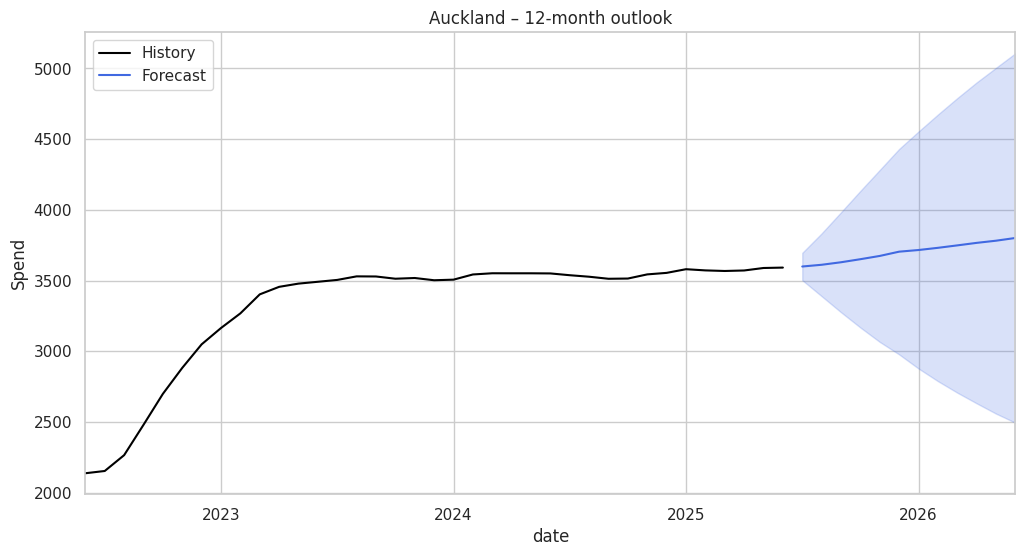

,date,forecast_spend,lo_95,hi_95
0,2025-07-31,"3,599.29","3,502.68","3,695.90"
1,2025-08-31,"3,611.53","3,389.44","3,833.61"
2,2025-09-30,"3,629.36","3,275.85","3,982.87"
3,2025-10-31,"3,650.96","3,167.67","4,134.26"
4,2025-11-30,"3,674.05","3,065.94","4,282.15"


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('forecast_spend').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('lo_95').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('hi_95').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('forecast_spend')):
  _plot_series(series, series_name, i)
  fig.legend(title='forecast_spend', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('lo_95')):
  _plot_series(series, series_name, i)
  fig.legend(title='lo_95', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('hi_95')):
  _plot_series(series, series_name, i)
  fig.legend(title='hi_95', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('forecast_spend')):
  _plot_series(series, series_name, i)
  fig.legend(title='forecast_spend', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['lo_95'].value_counts()
    for x_label, grp in _df_7.groupby('forecast_spend')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('forecast_spend')
_ = plt.ylabel('lo_95')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['hi_95'].value_counts()
    for x_label, grp in _df_8.groupby('lo_95')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('lo_95')
_ = plt.ylabel('hi_95')

In [18]:
# Refit on all available data
final_model = SARIMAX(
    y,
    order=best_order,
    seasonal_order=(best_sorder[0], best_sorder[1], best_sorder[2], seasonal_period),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

future_steps = 12
future_forecast = final_model.get_forecast(steps=future_steps)
f_mean = future_forecast.predicted_mean
f_ci   = future_forecast.conf_int()

# Plot last 3 years + next 12 months
plot_start = y.index.max() - pd.DateOffset(years=3)

ax = y[y.index >= plot_start].plot(label="History", color="black")
f_mean.plot(ax=ax, label="Forecast", color="royalblue")
ax.fill_between(f_ci.index, f_ci.iloc[:,0], f_ci.iloc[:,1], color="royalblue", alpha=0.2)
ax.set_title(f"{target_region} – 12-month outlook")
ax.set_ylabel("Spend")
plt.legend()
plt.show()

# Export forecasts for your report / Power BI
out = pd.DataFrame({"date": f_mean.index, "forecast_spend": f_mean.values,
                    "lo_95": f_ci.iloc[:,0].values, "hi_95": f_ci.iloc[:,1].values})
out.to_csv(f"{target_region.lower().replace(' ','_')}_forecast_next12m.csv", index=False)

# Format the spend columns to two decimal places
out['forecast_spend'] = out['forecast_spend'].map('{:,.2f}'.format)
out['lo_95'] = out['lo_95'].map('{:,.2f}'.format)
out['hi_95'] = out['hi_95'].map('{:,.2f}'.format)

# Remove time from date column
out['date'] = out['date'].dt.date

display(out.head())

**Rank Regions by Recent Recovery and Momentum**

In [20]:
# Recovery level: last month index
last_idx = region_idx.iloc[-1].sort_values(ascending=False).rename("recovery_index_last")

# Momentum: average YoY over last 6 months
momentum = (region_ts.pct_change(12).iloc[-6:] * 100).mean().sort_values(ascending=False).rename("yoy_6m_avg")

summary = pd.concat([last_idx, momentum], axis=1).dropna().sort_values("recovery_index_last", ascending=False)

# Format the numerical columns to two decimal places
summary['recovery_index_last'] = summary['recovery_index_last'].map('{:,.2f}'.format)
summary['yoy_6m_avg'] = summary['yoy_6m_avg'].map('{:,.2f}'.format)

display(summary.head(10))

,recovery_index_last,yoy_6m_avg
region,,
Canterbury,122.92,-0.26
Taranaki,120.83,-6.13
Tasman,120.66,-2.46
West Coast,119.56,1.28
Gisborne,118.20,1.93
Waikato,117.79,-0.48
Manawatu-Wanganui,117.15,-2.94
Southland,115.85,0.71
Auckland,115.59,1.03
